In [1]:
%cd ..

d:\autograde


# Image cutting

## Testing

### Cut images

In [2]:
from data_engineering.cutting import read_sorted_contours, convert_sorted_contours_to_matrix, cut_image_based_on_matrix
# Example usage
image_path = "data/Trainning_SET/Images/IMG_1581_iter_0.jpg"
sorted_contours_path = "data/created/json/sorted_contours/IMG_1581_iter_0_contours_sorted.txt"
output_dir = "data/trash/cropped_images"

sorted_contours = read_sorted_contours(sorted_contours_path)
matrix = convert_sorted_contours_to_matrix(sorted_contours)
cut_image_based_on_matrix(image_path, matrix, output_dir)

Cropped 16 images from IMG_1581_iter_0


### Cut labels

In [3]:
from data_engineering.cutting import create_cropped_labels
# Example Usage
image_path = "data/Trainning_SET/Images/IMG_1581_iter_0.jpg"
label_path = "data/Trainning_SET/Labels/IMG_1581_iter_0.txt"
sorted_contours_path = "data/created/json/sorted_contours/IMG_1581_iter_0_contours_sorted.txt"
output_label_dir = "data/trash/cropped_labels"  # Directory to save cropped labels

sorted_contours = read_sorted_contours(sorted_contours_path)
matrix = convert_sorted_contours_to_matrix(sorted_contours)
create_cropped_labels(image_path, matrix, label_path, output_label_dir)

In [4]:
from data_engineering.pivot_contour import show_sheet

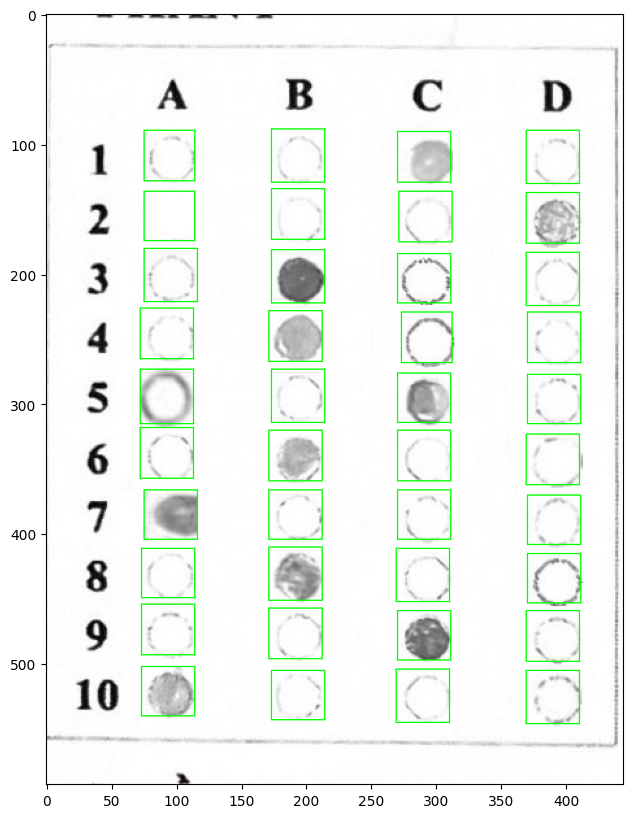

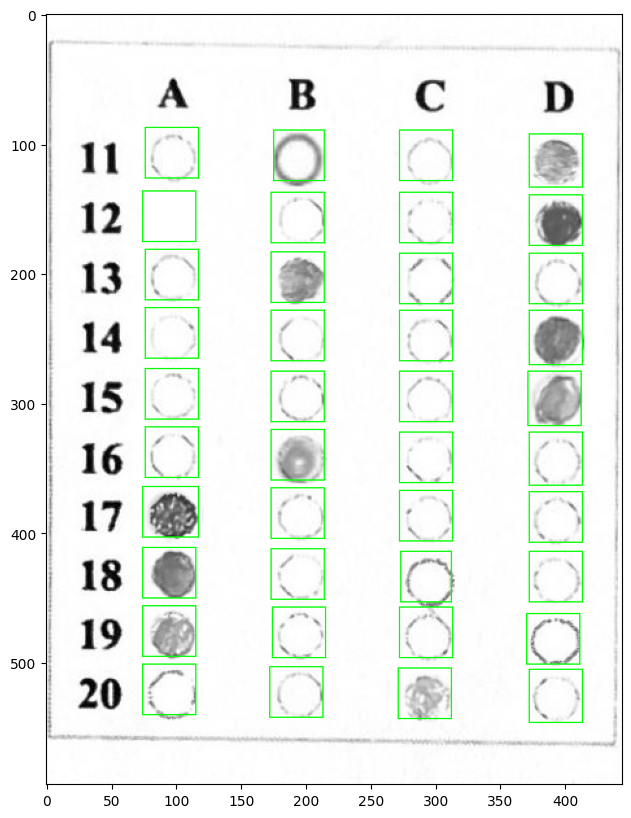

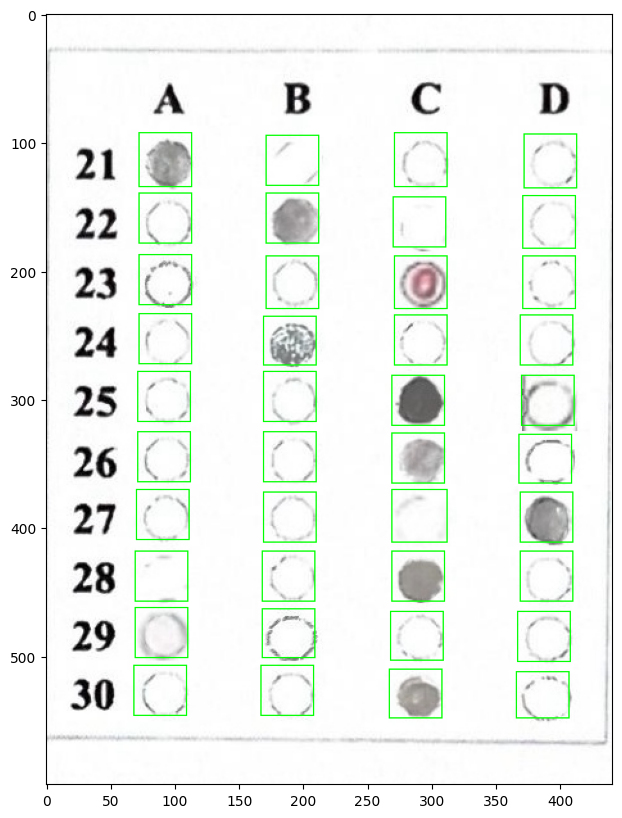

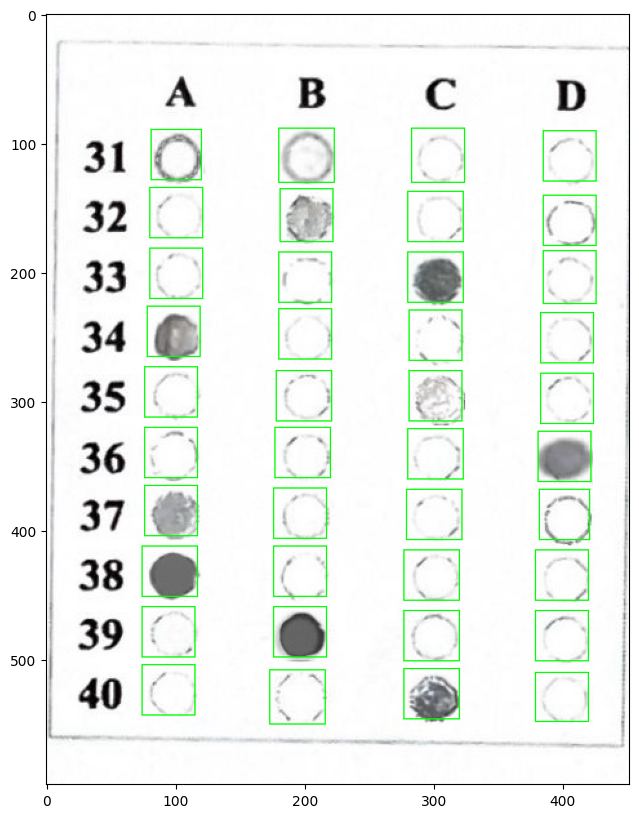

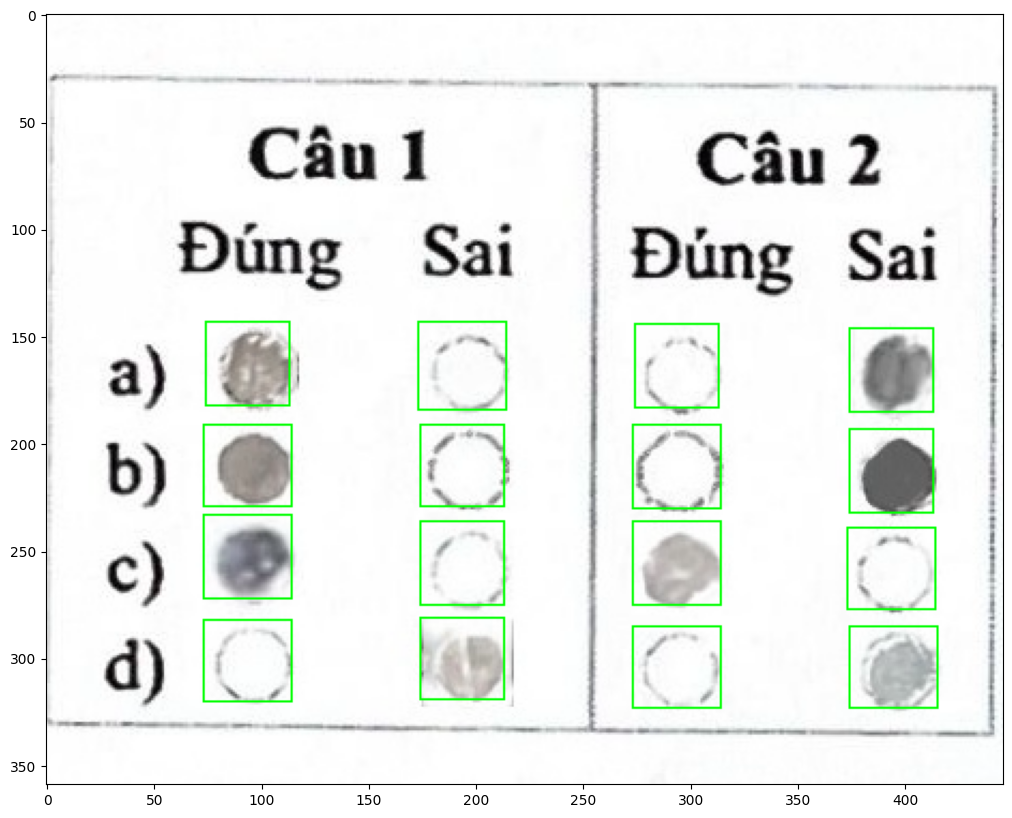

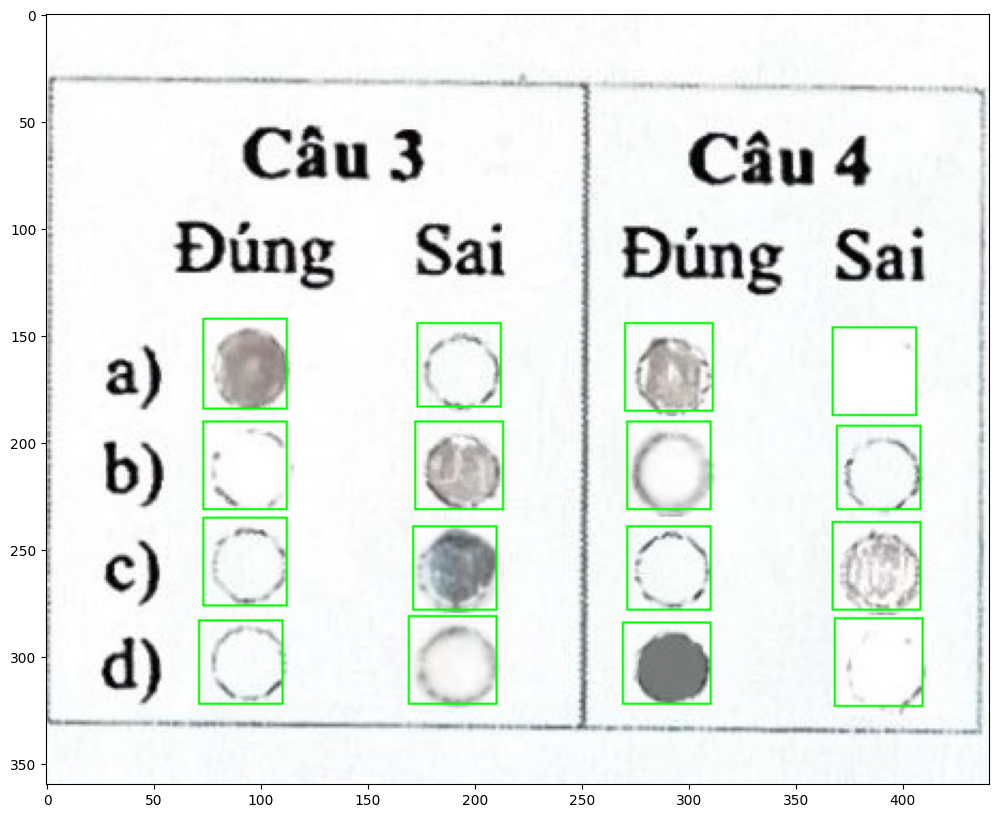

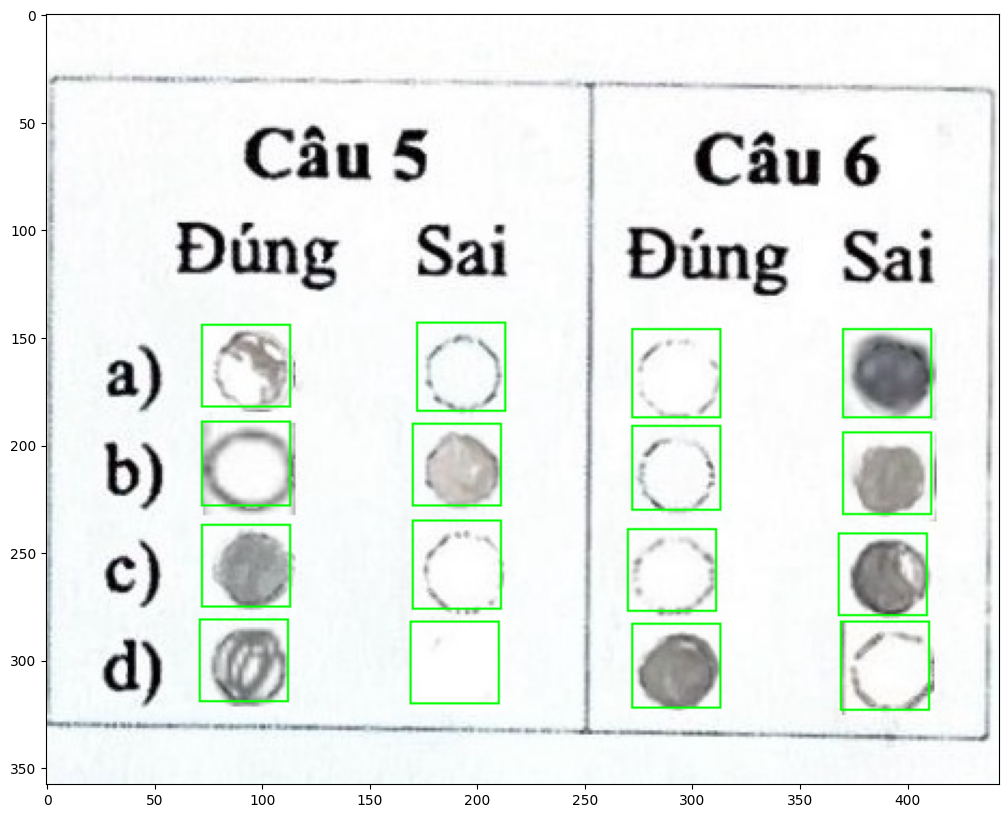

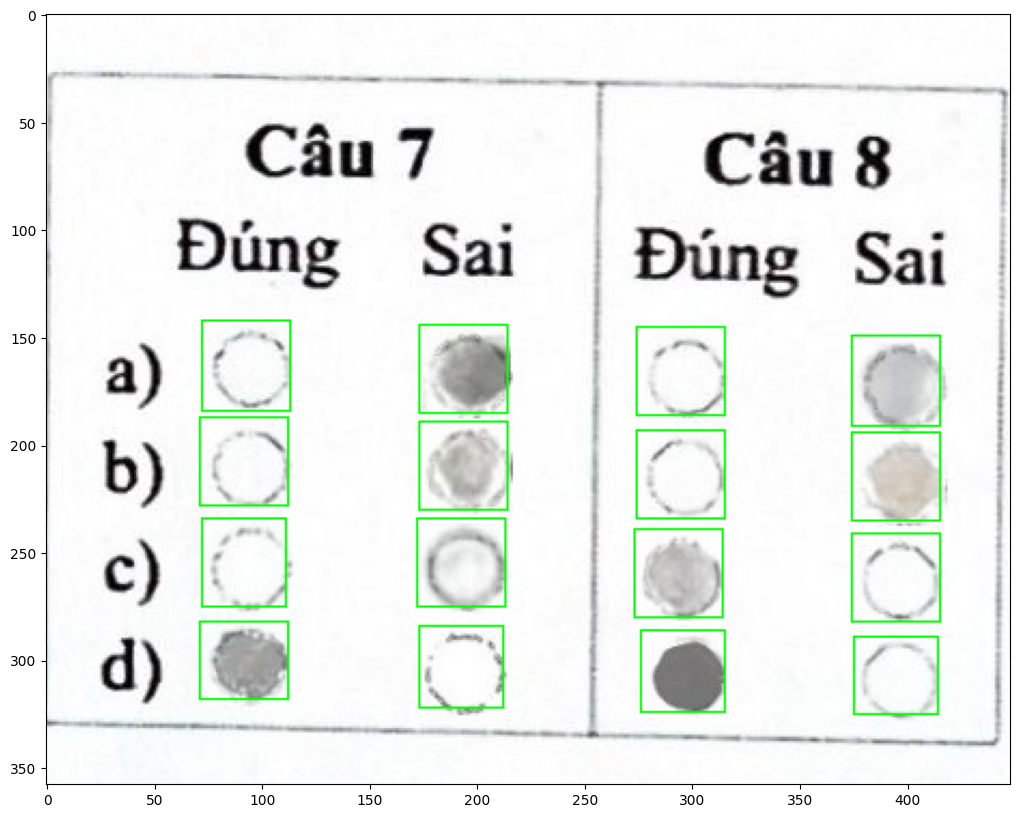

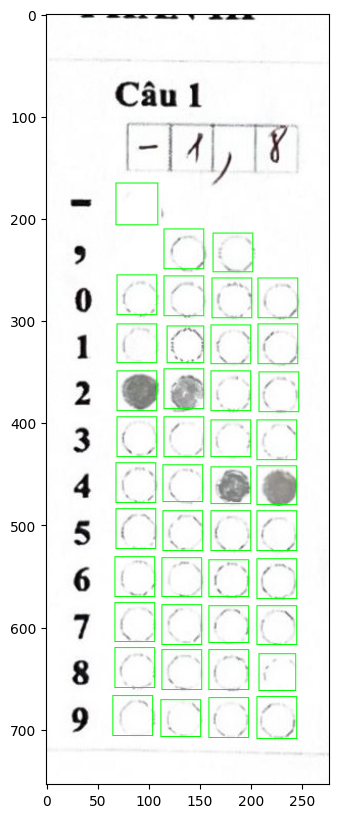

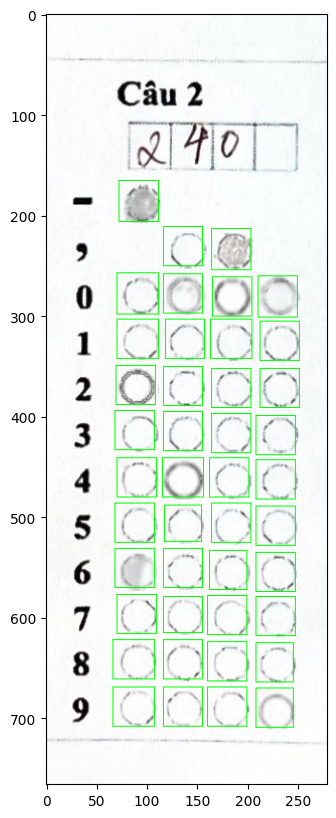

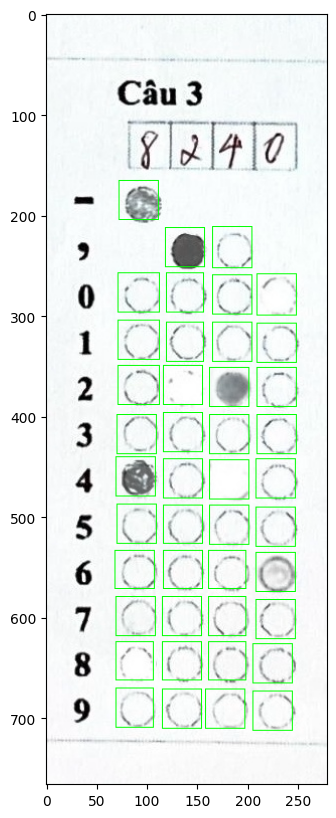

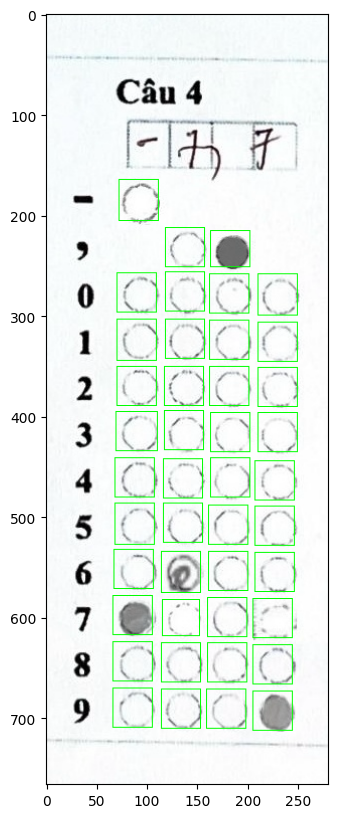

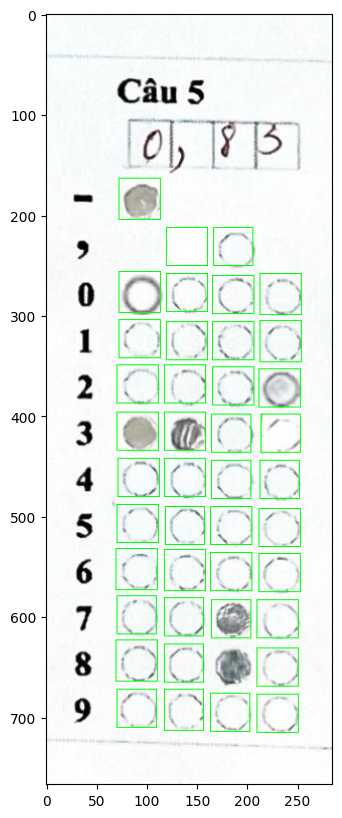

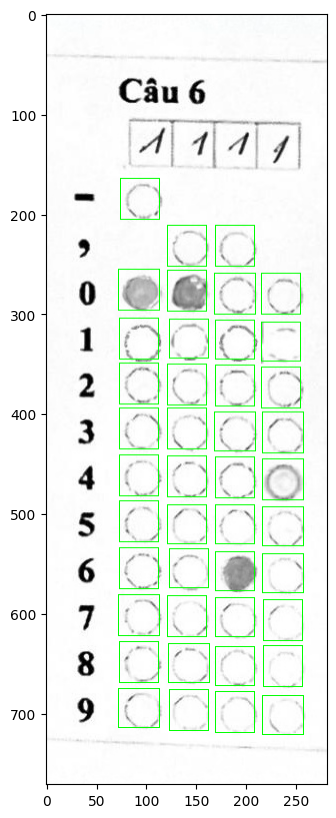

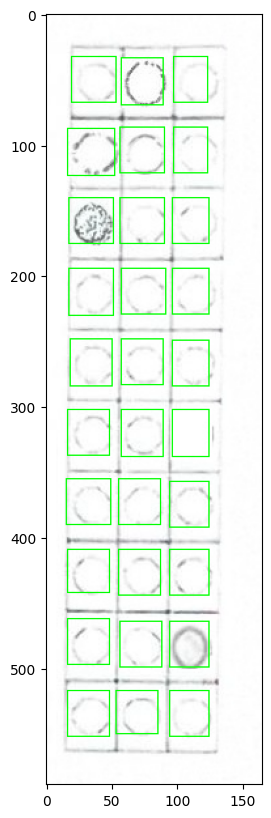

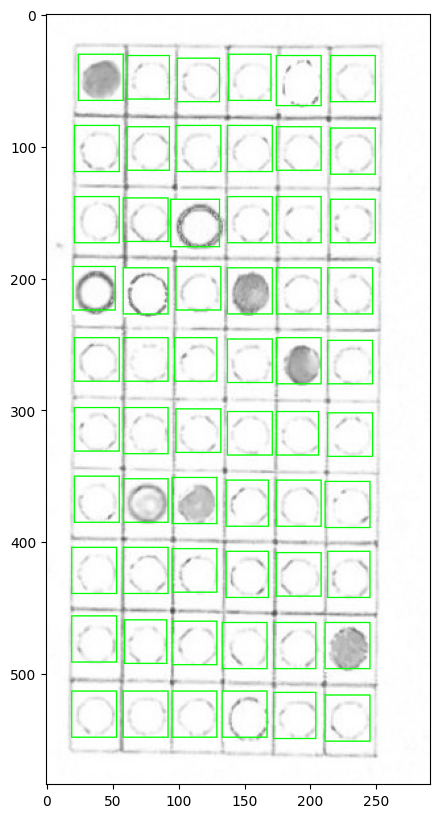

In [6]:
import cv2
import os
import numpy as np
def visualize_cropped_labels(cropped_image_dir, cropped_label_dir):
    """
    Visualizes the cropped labels on the corresponding cropped images.

    Args:
        cropped_image_dir: Directory containing the cropped images.
        cropped_label_dir: Directory containing the cropped label files.
    """

    for image_file in os.listdir(cropped_image_dir):
        if image_file.endswith(".jpg"):
            image_name = os.path.splitext(image_file)[0]
            label_file = f"{image_name}.txt"
            label_path = os.path.join(cropped_label_dir, label_file)
            image_path = os.path.join(cropped_image_dir, image_file)

            # Read the cropped image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not read image at {image_path}")
                continue

            img_height, img_width = img.shape[:2]

            # Read and draw the cropped labels
            try:
                with open(label_path, 'r') as f:
                    for line in f:
                        class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.strip().split())

                        # Convert normalized coordinates to absolute coordinates
                        x_center = int(x_center_norm * img_width)
                        y_center = int(y_center_norm * img_height)
                        width = int(width_norm * img_width)
                        height = int(height_norm * img_height)

                        # Calculate top-left and bottom-right corner coordinates
                        x1 = int(x_center - width / 2)
                        y1 = int(y_center - height / 2)
                        x2 = int(x_center + width / 2)
                        y2 = int(y_center + height / 2)

                        # Draw the bounding box
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Green rectangle

                        # Put the class label (if you have a mapping of class IDs to names)
                        # class_name = class_id_to_name.get(int(class_id), str(int(class_id)))  # Replace with your mapping
                        # cv2.putText(img, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Display the image with bounding boxes
                show_sheet(img)

            except FileNotFoundError:
                print(f"Error: Label file not found: {label_path}")

# Example Usage:
cropped_image_dir = "data/trash/cropped_images"  # Directory where you saved the cropped images
cropped_label_dir = "data/trash/cropped_labels"  # Directory where you saved the cropped labels

visualize_cropped_labels(cropped_image_dir, cropped_label_dir)

In [7]:
from data_engineering.cutting import reverse_cropped_labels


# Example Usage:
cropped_label_dir = "data/trash/cropped_labels"  # Directory containing cropped label files
original_image_path = "data/Trainning_SET/Images/IMG_1581_iter_0.jpg"  # Path to the original image
sorted_contours_path = "data/created/json/sorted_contours/IMG_1581_iter_0_contours_sorted.txt"
output_label_path = "data/trash/IMG_1581_reversed.txt"  # Path to save the reversed labels

sorted_contours = read_sorted_contours(sorted_contours_path)
matrix = convert_sorted_contours_to_matrix(sorted_contours)
reverse_cropped_labels(cropped_label_dir, original_image_path, matrix, output_label_path)

Reversed labels saved to: data/trash/IMG_1581_reversed.txt


In [9]:
import numpy as np

def compare_labels(original_label_path, reversed_label_path, tolerance=1e-4):
    """
    Compares the original and reversed YOLOv8 label files, handling potential format errors.

    Args:
        original_label_path: Path to the original YOLOv8 label file.
        reversed_label_path: Path to the reversed (reconstructed) YOLOv8 label file.
        tolerance: The allowed difference between corresponding coordinates.
    """

    try:
        with open(original_label_path, 'r') as f:
            original_labels = [line.strip().split() for line in f]
    except FileNotFoundError:
        print(f"Error: Original label file not found: {original_label_path}")
        return

    try:
        with open(reversed_label_path, 'r') as f:
            reversed_labels = [line.strip().split() for line in f]
    except FileNotFoundError:
        print(f"Error: Reversed label file not found: {reversed_label_path}")
        return

    if len(original_labels) != len(reversed_labels):
        print("Warning: The number of labels in the original and reversed files does not match.")

    num_mismatched = 0
    num_invalid_format = 0

    for i, (orig_label, rev_label) in enumerate(zip(original_labels, reversed_labels)):
        try:
            # Check if both labels have 6 values (or 5 for the reversed one if you are not adding class_id)
            if len(orig_label) != 5 or len(rev_label) != 5:
                raise ValueError("Invalid label format")

            orig_class_id, orig_x_center, orig_y_center, orig_width, orig_height = map(float, orig_label)
            rev_class_id, rev_x_center, rev_y_center, rev_width, rev_height = map(float, rev_label)

            if int(orig_class_id) != int(rev_class_id):
                print(f"Mismatch in class ID at line {i + 1}: Original={int(orig_class_id)}, Reversed={int(rev_class_id)}")
                num_mismatched += 1

            if not np.allclose([orig_x_center, orig_y_center, orig_width, orig_height],
                               [rev_x_center, rev_y_center, rev_width, rev_height],
                               atol=tolerance):
                print(f"Mismatch in coordinates at line {i + 1}:")
                print(f"  Original: x_center={orig_x_center:.6f}, y_center={orig_y_center:.6f}, width={orig_width:.6f}, height={orig_height:.6f}")
                print(f"  Reversed: x_center={rev_x_center:.6f}, y_center={rev_y_center:.6f}, width={rev_width:.6f}, height={rev_height:.6f}")
                num_mismatched += 1

        except ValueError:
            print(f"Error: Invalid label format in line {i + 1}. Skipping comparison for this line.")
            num_invalid_format += 1

    if num_mismatched == 0 and num_invalid_format == 0:
        print("Comparison successful: All labels match within the specified tolerance.")
    else:
        print(f"Comparison failed: {num_mismatched} mismatches and {num_invalid_format} invalid format errors found.")

# Example Usage:
original_label_path = "data/Trainning_SET/Labels/IMG_1581_iter_0.txt"  # Path to the original label file
reversed_label_path = "data/trash/IMG_1581_reversed.txt"  # Path to the reversed label file

compare_labels(original_label_path, reversed_label_path)

Comparison successful: All labels match within the specified tolerance.
